In [25]:
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# FUNCTIONS

def beta(stock,etf ):
    # Beta = covariance/variance   --- https://www.investopedia.com/terms/b/beta.asp ---
    cov_matrix = np.cov(stock, etf, ddof=0)
    var_stock = cov_matrix[0,0]
    cov_stock_etf = cov_matrix[0,1]
    return cov_stock_etf/var_stock

def sharpe_ratio(benchmark_returns, portfolio_returns):
    # ---      https://www.educba.com/sharpe-ratio-formula/    --- 
    # Sharpe Ratio = (expected rate of return of portfolio - risk free rate)/standard deviation of portfolio return
    # To be adjusted for interval used. Here, adjust by sqrt(252)
    portfolio_mean_return = portfolio_returns.mean()
    risk_free_rate = benchmark_returns.mean()
    volatility = portfolio_returns.std()
    return ((portfolio_mean_return - risk_free_rate)/volatility) * (252**0.5)

def drawdown(stock_close): # returns weekly drawdown
    weekly_data = stock_close.resample('7D').ffill() # borrowed from: https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
    rolling_max = weekly_data.rolling(window=52,min_periods=1).max() # 52-week high
    return (weekly_data - rolling_max)/rolling_max # difference between current price and current max as ratio of current max

In [27]:
etfs = ['DIA','IWM','SPY']
stocks = ['AMD', 'BRK-B','DIS','LAC','META','TSM','UAL']
stock_cols = ['Portfolio_Weight', 'Annualized_Volatility','Beta_Against_SPY','Beta_Against_IWM','Beta_Against_DIA',
'Avg_Weekly_Drawdown','Max_Weekly_Drawdown','Total_Return','Annualized_Total_Return']

n = len(stocks)
weight = 1/n

In [28]:
data = yf.download(stocks+etfs, period='10y')
data = data['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [29]:
# REQUIREMENT 1: CONSTITUENT STOCK RISK ANALYSIS

# Create stocks dataframe
stocks_df = pd.DataFrame(index = stocks, columns=stock_cols)

for ticker in stocks:
    stock = data[ticker]
    stocks_df.loc[ticker, 'Ticker'] = ticker
    stocks_df.loc[ticker, 'Portfolio_Weight'] = weight 
    stocks_df.loc[ticker, 'Annualized_Volatility'] = stock[-63:].std()*(252**0.5) 
    stocks_df.loc[ticker, 'Beta_Against_SPY'] = beta(stock[-252: ], data['SPY'][-252: ])
    stocks_df.loc[ticker, 'Beta_Against_IWM'] = beta(stock[-252: ], data['IWM'][-252: ])
    stocks_df.loc[ticker, 'Beta_Against_DIA'] = beta(stock[-252: ], data['DIA'][-252: ])
    stocks_df.loc[ticker, 'Avg_Weekly_Drawdown'] = drawdown(stock).mean()
    stocks_df.loc[ticker, 'Max_Weekly_Drawdown'] = drawdown(stock).min()
    # --- RETURNS ---( www.corporatefinanceinstitute.com )
    # Absolute return = (final price - initial price)/initial price 
    # Annualized Total return = (((final value/initial value)^(1/n)) - 1) 
    stocks_df.loc[ticker, 'Total_Return'] = (stock[-1] - stock[0])/stock[0] 
    stocks_df.loc[ticker, 'Annualized_Total_Return'] = (((stock[-1]/stock[0])**(1/10))-1)
stocks_df

,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return,Ticker
AMD,0.142857,116.275395,1.091731,0.445728,0.321483,-0.189152,-0.633904,30.827453,0.413449,AMD
BRK-B,0.142857,75.006314,0.81227,0.357301,0.534275,-0.057521,-0.255953,2.06421,0.118489,BRK-B
DIS,0.142857,129.340955,1.326016,0.606425,0.428185,-0.10883,-0.505998,0.966012,0.069938,DIS
LAC,0.142857,34.612815,3.519215,1.673649,0.977728,-0.288511,-0.722222,27.070588,0.395806,LAC
META,0.142857,414.935863,0.435617,0.1656,0.080323,-0.113992,-0.741811,5.469559,0.205279,META
TSM,0.142857,119.758052,1.639459,0.702216,0.742979,-0.095601,-0.560068,5.669483,0.208952,TSM
UAL,0.142857,81.337591,1.757788,0.926032,1.809864,-0.178901,-0.786944,0.771023,0.058821,UAL


In [30]:
# REQUIREMENT 2: PORTFOLIO RISK VS ETFS

portfolio_vs_etf_cols = ['Corr_against_ETF', 'Cov_against_ETF', 'Tracking_Errors', 'Sharpe_Ratio', 'Ann_Volatility_Spread']
portfolio_against_etf_df = pd.DataFrame(index = etfs, columns=portfolio_vs_etf_cols)

In [31]:
portfolio_returns = (data[stocks].pct_change()) * weight
portfolio_returns = portfolio_returns.sum(axis=1) # year-on-year portfolio pct change

In [32]:
returns_all_df = pd.concat([data[etfs].pct_change(), data[stocks].pct_change(), portfolio_returns], axis=1) # df of all returns (etf, stocks, portfolio)
cols = etfs + stocks
cols.append('Portfolio')
returns_all_df.columns = cols
corr_matrix = returns_all_df.corr(method="pearson")
cov_matrix = returns_all_df.cov()

In [33]:
for etf in etfs:
    portfolio_against_etf_df.loc[etf, 'Corr_against_ETF'] = corr_matrix['Portfolio'][etf]
    portfolio_against_etf_df.loc[etf, 'Cov_against_ETF'] = cov_matrix['Portfolio'][etf]
    # --- https://www.investopedia.com/terms/t/trackingerror.asp ---
    # Tracking Error = std(portfolio_returns - benchmark returns)
    portfolio_against_etf_df.loc[etf, 'Tracking_Errors'] = (returns_all_df['Portfolio'] - returns_all_df[etf]).std()
    # Sharpe Ratio: using info from 1 years worth of data. Can't use already calculated returns
    portfolio_against_etf_df.loc[etf, 'Sharpe_Ratio'] = sharpe_ratio(returns_all_df[etf], returns_all_df['Portfolio']) 
    portfolio_against_etf_df.loc[etf, 'Ann_Volatility_Spread'] = ((returns_all_df['Portfolio'].std())*(252**0.5)) - ((returns_all_df[etf].std())*(252**0.5))

portfolio_against_etf_df

,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
DIA,0.702631,0.000142,0.013291,0.659379,0.119237
IWM,0.737831,0.000187,0.012462,0.70531,0.075372
SPY,0.74772,0.000152,0.012577,0.630425,0.118493


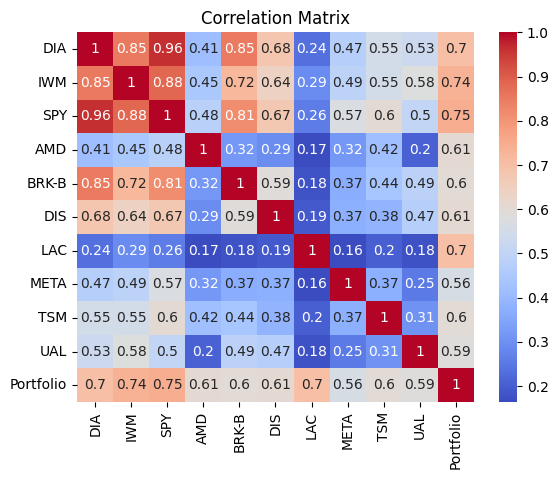

In [34]:
# REQUIREMENT NUMBER 3: CORRELATION MATRIX

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [35]:
stocks_df = stocks_df.style.set_caption('CONSTITUENT STOCK RISK ANALYSIS')
stocks_df

,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return,Ticker
AMD,0.142857,116.275395,1.091731,0.445728,0.321483,-0.189152,-0.633904,30.827453,0.413449,AMD
BRK-B,0.142857,75.006314,0.812270,0.357301,0.534275,-0.057521,-0.255953,2.064210,0.118489,BRK-B
DIS,0.142857,129.340955,1.326016,0.606425,0.428185,-0.108830,-0.505998,0.966012,0.069938,DIS
LAC,0.142857,34.612815,3.519215,1.673649,0.977728,-0.288511,-0.722222,27.070588,0.395806,LAC
META,0.142857,414.935863,0.435617,0.165600,0.080323,-0.113992,-0.741811,5.469559,0.205279,META
TSM,0.142857,119.758052,1.639459,0.702216,0.742979,-0.095601,-0.560068,5.669483,0.208952,TSM
UAL,0.142857,81.337591,1.757788,0.926032,1.809864,-0.178901,-0.786944,0.771023,0.058821,UAL


In [36]:
portfolio_against_etf_df = portfolio_against_etf_df.style.set_caption('PORTFOLIO RISK VS ETFS')
portfolio_against_etf_df

,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
DIA,0.702631,0.000142,0.013291,0.659379,0.119237
IWM,0.737831,0.000187,0.012462,0.705310,0.075372
SPY,0.747720,0.000152,0.012577,0.630425,0.118493
